In [17]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
import pandas as pd
import cv2
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.metrics import  classification_report
import features as features
import utilities as util
import timeit


In [18]:
'''
parms: train data (X_train)
       test data  (X_test)
       train classes  (y_test)

----------------------------

returns: test classes  (y_test)
'''


def svm_train(X_train,y_train, kernel='rbf'):
    clf = svm.SVC(kernel=kernel)
    clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
    return clf

In [19]:
'''
parms: train data (X_train)
       test data  (X_test)
       train classes  (y_train)

----------------------------

returns: test classes  (y_test)
'''

def random_forest_train(X_train,y_train, max_depth=2, n_estimators=50):
    clf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)
    clf.fit(X_train, y_train)
#     y_pred=clf.predict(X_test)
    return clf

In [20]:
'''
parms: train data (X_train)
       test data  (X_test)
       train classes  (y_train)

----------------------------

returns: test classes  (y_test)
'''

def knn_train(X_train,y_train, n_neighbors=5):
        neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
        neigh.fit(X_train, y_train)
       #  y_pred=neigh.predict(X_test)
        return neigh

In [34]:
'''
parms: test classes of models tarined by  --> 1) svm
                                              2) random_forest
                                              3)knn

----------------------------

returns: test classes after taking the vote of the 3 classes
'''

def voting_system(y_pred_svm,y_pred_random_forest,y_pred_knn):
    y_pred=np.add(np.add(y_pred_knn,y_pred_svm),y_pred_random_forest)
    y_pred[y_pred <=1]=0
    y_pred[y_pred >1]=1  
    return y_pred


In [22]:
def apply_PCA_train(X,n_components=5, verbose=False):
    sc = StandardScaler()
    X_copy = np.copy(X)
    X_copy = sc.fit_transform(X_copy)
    pca = PCA(n_components = n_components)
    X_copy = pca.fit_transform(X_copy)
    
    if(verbose):
        print("preserved vairance: ", np.sum(pca.explained_variance_ratio_))
    
    return pca, sc, X_copy

In [23]:
def pre_process(image):
    thresh = util.threshold_image(image)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    return contours

In [24]:
def extract_hinge(contours):
    # extract features
    hinge_feature = features.get_hinge_features(contours)

    return hinge_feature

In [25]:
def extract_cold(contours):
    cold_feature = features.get_cold_features(contours)
    
    return cold_feature

In [26]:
def extract_hog(image):
    hog_feature = features.extract_hog_features(image)
    return hog_feature
    

In [27]:
def apply_PCA_test(X, pca, sc, verbose=False):
    X_copy = np.copy(X)
    X_copy = sc.transform(X_copy)
    X_copy = pca.transform(X_copy)
    
    if(verbose):
        print("preserved vairance: ", np.sum(pca.explained_variance_ratio_))
    
    return X_copy

In [28]:

###### Split data to train, validate, and test
# set aside 20% of train and test data for evaluation
def split_data(X,Y):

    X_train, X_test, y_train, y_test = train_test_split(X, Y,
        test_size=0.25, random_state = 45)

    # Use the same function above for the validation set
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
        test_size=0.5, random_state= 45) # 0.25 x 0.8 = 0.2

    return X_train, y_train, X_val, y_val, X_test, y_test


In [29]:
#Read imags and split data
female_imgs = util.read_imgs('./data/Female/Female/')

female_labels = np.zeros(len(female_imgs))


male_imgs = util.read_imgs('./data/Male/Male/')
male_labels = np.ones(len(male_imgs))


X = np.append(female_imgs, male_imgs)
Y = np.append(female_labels, male_labels)

# X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, Y)
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, Y)


c:\Users\osama\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [30]:
print((X.shape))

(363,)


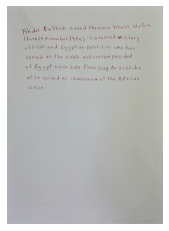

In [31]:
util.showbbbbbbb_image(X[0])

In [35]:
#Train the classifier 
X_hinge = []
X_cold = []
X_hog = []




# Calculating features for images, and apply pca after that 
# Another change would be to iterate over X_train only and do not split after pca
for i in range(len(X)):
    # extract features
    contours = pre_process(X[i])

    hinge_features = features.get_hinge_features(contours)
    X_hinge.append(hinge_features)

    cold_features = features.get_cold_features(contours)
    X_cold.append(cold_features)

    hog_features = features.extract_hog_features(X[i])
    X_hog.append(hog_features)


hinge_pca_50, hinge_sc_50, X_hinge_50 = apply_PCA_train(X_hinge, n_components=50)
hinge_pca_60, hinge_sc_60, X_hinge_60 = apply_PCA_train(X_hinge, n_components=60)
cold_pca_180, cold_sc_180, X_cold_180 = apply_PCA_train(X_cold, n_components=180)
hog_pca_170, hog_sc_170, X_hog_170 = apply_PCA_train(X_hog, n_components=170)


################ If you use these, note that you don't need any feature extraction. Just train and predict
X_train_1 , X_val_1 , X_train_2 , X_val_2 , X_train_3 , X_val_3 , X_train_4 , X_val_4 , y_train, y_val = train_test_split(X_hinge_50,
                                                                                                                            X_hinge,
                                                                                                                            np.hstack((X_hinge_60, X_cold_180, X_hog_170)),
                                                                                                                            X_hinge_60,
                                                                                                                            Y,
                                                                                                                            test_size=0.25,
                                                                                                                            random_state=45
                                                                                                                            ) 




X_test_1 , X_val_1 , X_test_2 , X_val_2 , X_test_3 , X_val_3 , X_test_4 , X_val_4 , y_test, y_val = train_test_split(X_val_1,
                                                                                                                            X_val_2,
                                                                                                                            X_val_3,
                                                                                                                            X_val_4,
                                                                                                                            y_val,
                                                                                                                            test_size=0.5,
                                                                                                                            random_state=45
                                                                                                                            ) 






svm_1 = svm_train(X_train_1,y_train)
# svm_1 = svm_train(X_hinge_50,y_train)

###############################################


rft_1 = random_forest_train(X_train_2, y_train)
# rft_1 = random_forest_train(X_hinge, y_train)

##################################################


knn_1 = knn_train(X_train_1, y_train)

# knn_1 = knn_train(X_hinge_50, y_train)

##################################################

svm_2 = svm_train( X_train_3,y_train)

# svm_2 = svm_train( np.hstack((X_hinge_60, X_cold_180, X_hog_170)),y_train)

##################################################

rft_2 = rft_1

# rft_2 = rft_1

##################################################

knn_2 = knn_train(X_train_4, y_train)

# knn_2 = knn_train(X_hinge_pca_60, y_train)


d:\Work\College\Third_Year\NN\Project\Handwriting-Based-Gender-Classification\features.py:96: RuntimeWarning: divide by zero encountered in log10
  rhos_log_space = np.log10(rhos)


# Validation on the first 3 classifiers

In [37]:
#Validate


start = timeit.default_timer()
total_time = 0
feature_vector = []

# Calculating features for images
for i in range(len(X_val)):
    # extract features
    contours = pre_process(X_val[i])

    hinge_features = features.get_hinge_features(contours)
    feature_vector.append(hinge_features)

feature_vector_pca = apply_PCA_test(feature_vector, hinge_pca_50, hinge_sc_50)

y_pred_svm = svm_1.predict(X_val_1)

stop = timeit.default_timer()

svm_1_accuracy = metrics.accuracy_score(y_true=y_val, y_pred=y_pred_svm)

print("Accuracy of SVM_1:", svm_1_accuracy)

print('Time: ', stop - start)
total_time += (stop - start)
#######################################################

start = timeit.default_timer()

feature_vector = []

# Calculating features for images
for i in range(len(X_val)):
    # extract features
    contours = pre_process(X_val[i])

    hinge_features = features.get_hinge_features(contours)
    feature_vector.append(hinge_features)


y_pred_rft = rft_1.predict(X_val_2)

stop = timeit.default_timer()

rft_1_accuracy = metrics.accuracy_score(y_true=y_val, y_pred=y_pred_rft)

print("Accuracy of random forest 1 :", rft_1_accuracy)    

print('Time: ', stop - start)

total_time += (stop - start)

#######################################################

start = timeit.default_timer()

feature_vector = []

# Calculating features for images
for i in range(len(X_val)):
    # extract features
    contours = pre_process(X_val[i])

    hinge_features = features.get_hinge_features(contours)
    feature_vector.append(hinge_features)

feature_vector_pca = apply_PCA_test(feature_vector, hinge_pca_50, hinge_sc_50)

y_pred_knn = knn_1.predict(X_val_1)

stop = timeit.default_timer()


knn_1_accuracy = metrics.accuracy_score(y_true=y_val, y_pred=y_pred_knn)

print("Accuracy of knn 1:", knn_1_accuracy)    

print('Time: ', stop - start)

total_time += (stop - start)

#######################################################

ypred_voting_system = voting_system(y_pred_svm=y_pred_svm, y_pred_random_forest=y_pred_rft, y_pred_knn=y_pred_knn)

voting_sys_accuracy = metrics.accuracy_score(y_true=y_val, y_pred=ypred_voting_system)

print("Accuracy of voting system", voting_sys_accuracy)    

print('Time: ', total_time)



Accuracy of SVM_1: 0.782608695652174
Time:  9.914391299999807
Accuracy of random forest 1 : 0.6956521739130435
Time:  9.914938500000062
Accuracy of knn 1: 0.7391304347826086
Time:  9.847731700000168
Accuracy of voting system 0.782608695652174
Time:  29.677061500000036


# Test on the first 3 classifiers

In [38]:
#Test

start = timeit.default_timer()
total_time = 0
feature_vector = []

# Calculating features for images
for i in range(len(X_test)):
    # extract features
    contours = pre_process(X_test[i])

    hinge_features = features.get_hinge_features(contours)
    feature_vector.append(hinge_features)

feature_vector_pca = apply_PCA_test(feature_vector, hinge_pca_50, hinge_sc_50)

y_pred_svm = svm_1.predict(X_test_1)

stop = timeit.default_timer()

svm_1_accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_svm)

print("Accuracy of SVM_1:", svm_1_accuracy)

print('Time: ', stop - start)
total_time += (stop - start)
#######################################################

start = timeit.default_timer()

feature_vector = []

# Calculating features for images
for i in range(len(X_test)):
    # extract features
    contours = pre_process(X_test[i])

    hinge_features = features.get_hinge_features(contours)
    feature_vector.append(hinge_features)


y_pred_rft = rft_1.predict(X_test_2)

stop = timeit.default_timer()

rft_1_accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_rft)

print("Accuracy of random forest 1 :", rft_1_accuracy)    

print('Time: ', stop - start)

total_time += (stop - start)

#######################################################

start = timeit.default_timer()

feature_vector = []

# Calculating features for images
for i in range(len(X_test)):
    # extract features
    contours = pre_process(X_test[i])

    hinge_features = features.get_hinge_features(contours)
    feature_vector.append(hinge_features)

feature_vector_pca = apply_PCA_test(feature_vector, hinge_pca_50, hinge_sc_50)

y_pred_knn = knn_1.predict(X_test_1)

stop = timeit.default_timer()


knn_1_accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_knn)

print("Accuracy of knn 1:", knn_1_accuracy)    

print('Time: ', stop - start)

total_time += (stop - start)

#######################################################

ypred_voting_system = voting_system(y_pred_svm=y_pred_svm, y_pred_random_forest=y_pred_rft, y_pred_knn=y_pred_knn)

voting_sys_accuracy = metrics.accuracy_score(y_true=y_test, y_pred=ypred_voting_system)

print("Accuracy of voting system", voting_sys_accuracy)    

print('Time: ', total_time)



Accuracy of SVM_1: 0.8222222222222222
Time:  9.550628399999823
Accuracy of random forest 1 : 0.6888888888888889
Time:  9.57288299999982
Accuracy of knn 1: 0.7777777777777778
Time:  9.83887760000016
Accuracy of voting system 0.8
Time:  28.962388999999803


# Validate on the second 3 classifiers

In [39]:
#Validate


total_time = 0
feature_vector = []

list_hinge_features = []
list_cold_features = []
list_hog_features = []

start = timeit.default_timer()

# Calculating features for images
for i in range(len(X_val)):
    # extract features
    contours = pre_process(X_val[i])

    list_hinge_features.append(features.get_hinge_features(contours))
    list_cold_features.append(features.get_cold_features(contours))

    list_hog_features.append(features.extract_hog_features(X_val[i]))

X_hinge_60 = apply_PCA_test(list_hinge_features, hinge_pca_60 ,hinge_sc_60)
X_cold_180 = apply_PCA_test(list_cold_features, cold_pca_180, cold_sc_180)
X_hog_170 = apply_PCA_test(list_hog_features, hog_pca_170, hog_sc_170)


feature_vector = np.hstack((X_hinge_60,X_cold_180, X_hog_170))

y_pred_svm = svm_2.predict(X_val_3)

stop = timeit.default_timer()

svm_2_accuracy = metrics.accuracy_score(y_true=y_val, y_pred=y_pred_svm)

print("Accuracy of SVM_2:", svm_2_accuracy)

print('Time: ', stop - start)
total_time += (stop - start)
#######################################################

start = timeit.default_timer()

feature_vector = []

# Calculating features for images
for i in range(len(X_val)):
    # extract features
    contours = pre_process(X_val[i])

    hinge_features = features.get_hinge_features(contours)
    feature_vector.append(hinge_features)


y_pred_rft = rft_2.predict(X_val_2)

stop = timeit.default_timer()

rft_2_accuracy = metrics.accuracy_score(y_true=y_val, y_pred=y_pred_rft)

print("Accuracy of random forest 2 :", rft_2_accuracy)    

print('Time: ', stop - start)

total_time += (stop - start)

#######################################################

start = timeit.default_timer()

feature_vector = []

# Calculating features for images
for i in range(len(X_val)):
    # extract features
    contours = pre_process(X_val[i])

    hinge_features = features.get_hinge_features(contours)
    feature_vector.append(hinge_features)

feature_vector_pca = apply_PCA_test(feature_vector, hinge_pca_60, hinge_sc_60)

y_pred_knn = knn_2.predict(X_val_4)

stop = timeit.default_timer()


knn_2_accuracy = metrics.accuracy_score(y_true=y_val, y_pred=y_pred_knn)

print("Accuracy of knn 2:", knn_2_accuracy)    

print('Time: ', stop - start)

total_time += (stop - start)

#######################################################

ypred_voting_system = voting_system(y_pred_svm=y_pred_svm, y_pred_random_forest=y_pred_rft, y_pred_knn=y_pred_knn)

voting_sys_accuracy = metrics.accuracy_score(y_true=y_val, y_pred=ypred_voting_system)

print("Accuracy of voting system", voting_sys_accuracy)    

print('Time: ', total_time)



d:\Work\College\Third_Year\NN\Project\Handwriting-Based-Gender-Classification\features.py:96: RuntimeWarning: divide by zero encountered in log10
  rhos_log_space = np.log10(rhos)


Accuracy of SVM_2: 0.782608695652174
Time:  45.56771790000039
Accuracy of random forest 2 : 0.6956521739130435
Time:  9.436423500000274
Accuracy of knn 2: 0.717391304347826
Time:  9.381158200000755
Accuracy of voting system 0.782608695652174
Time:  64.38529960000142


# Test on the second 3 classifiers

In [41]:
#Validate


total_time = 0
feature_vector = []

list_hinge_features = []
list_cold_features = []
list_hog_features = []

start = timeit.default_timer()

# Calculating features for images
for i in range(len(X_test)):
    # extract features
    contours = pre_process(X_test[i])

    list_hinge_features.append(features.get_hinge_features(contours))
    list_cold_features.append(features.get_cold_features(contours))

    list_hog_features.append(features.extract_hog_features(X_test[i]))

X_hinge_60 = apply_PCA_test(list_hinge_features, hinge_pca_60 ,hinge_sc_60)
X_cold_180 = apply_PCA_test(list_cold_features, cold_pca_180, cold_sc_180)
X_hog_170 = apply_PCA_test(list_hog_features, hog_pca_170, hog_sc_170)


feature_vector = np.hstack((X_hinge_60,X_cold_180, X_hog_170))

y_pred_svm = svm_2.predict(X_test_3)

stop = timeit.default_timer()

svm_2_accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_svm)

print("Accuracy of SVM_2:", svm_2_accuracy)

print('Time: ', stop - start)
total_time += (stop - start)
#######################################################

start = timeit.default_timer()

feature_vector = []

# Calculating features for images
for i in range(len(X_test)):
    # extract features
    contours = pre_process(X_test[i])

    hinge_features = features.get_hinge_features(contours)
    feature_vector.append(hinge_features)


y_pred_rft = rft_2.predict(X_test_2)

stop = timeit.default_timer()

rft_2_accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_rft)

print("Accuracy of random forest 2 :", rft_2_accuracy)    

print('Time: ', stop - start)

total_time += (stop - start)

#######################################################

start = timeit.default_timer()

feature_vector = []

# Calculating features for images
for i in range(len(X_test)):
    # extract features
    contours = pre_process(X_test[i])

    hinge_features = features.get_hinge_features(contours)
    feature_vector.append(hinge_features)

feature_vector_pca = apply_PCA_test(feature_vector, hinge_pca_60, hinge_sc_60)

y_pred_knn = knn_2.predict(X_test_4)

stop = timeit.default_timer()


knn_2_accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_knn)

print("Accuracy of knn 2:", knn_2_accuracy)    

print('Time: ', stop - start)

total_time += (stop - start)

#######################################################

ypred_voting_system = voting_system(y_pred_svm=y_pred_svm, y_pred_random_forest=y_pred_rft, y_pred_knn=y_pred_knn)

voting_sys_accuracy = metrics.accuracy_score(y_true=y_test, y_pred=ypred_voting_system)

print("Accuracy of voting system", voting_sys_accuracy)    

print('Time: ', total_time)



d:\Work\College\Third_Year\NN\Project\Handwriting-Based-Gender-Classification\features.py:96: RuntimeWarning: divide by zero encountered in log10
  rhos_log_space = np.log10(rhos)


Accuracy of SVM_2: 0.7555555555555555
Time:  47.571817799999735
Accuracy of random forest 2 : 0.6888888888888889
Time:  9.73714629999995
Accuracy of knn 2: 0.8
Time:  9.280314900000121
Accuracy of voting system 0.7333333333333333
Time:  66.5892789999998


# Save final Classifier, PCA, and SC

In [44]:
import pickle

##################Save Classifiers
f = open("svm1.pkl", "wb")
pickle.dump(svm_1, f)
f.close()
###
f = open("rft_1.pkl", "wb")
pickle.dump(rft_1, f)
f.close()
###
f = open("knn_1.pkl", "wb")
pickle.dump(knn_1, f)
f.close()
###
f = open("svm_2.pkl", "wb")
pickle.dump(svm_2, f)
f.close()
###
f = open("rft_2.pkl", "wb")
pickle.dump(rft_2, f)
f.close()
###
f = open("knn_2.pkl", "wb")
pickle.dump(knn_2, f)
f.close()
#######################################Save PCA and standard scaler

f = open("hinge_pca_50.pkl", "wb")
pickle.dump(hinge_pca_50, f)
f.close()

f = open("hinge_sc_50.pkl", "wb")
pickle.dump(hinge_sc_50, f)
f.close()
###

f = open("hinge_pca_60.pkl", "wb")
pickle.dump(hinge_pca_60, f)
f.close()

f = open("hinge_sc_60.pkl", "wb")
pickle.dump(hinge_sc_60, f)
f.close()
###

f = open("cold_pca_180.pkl", "wb")
pickle.dump(cold_pca_180, f)
f.close()

f = open("cold_sc_180.pkl", "wb")
pickle.dump(cold_sc_180, f)
f.close()
###

f = open("hog_pca_170.pkl", "wb")
pickle.dump(hog_pca_170, f)
f.close()

f = open("hog_sc_170.pkl", "wb")
pickle.dump(hog_sc_170, f)
f.close()
###


# Call the final pipeline

In [54]:
def complete_pipeline(X, clf, pca, sc, type="svm_1"):

    #This is the final choice we made depending on the accuracy and execution time
    feature_vector = []
    time = []

    # Calculating features for images
    for i in range(len(X)):
        # extract features
        start = timeit.default_timer()


        contours = pre_process(X[i])

        hinge_features = features.get_hinge_features(contours)
        feature_vector.append(hinge_features)

        feature_vector_pca = apply_PCA_test(feature_vector, pca, sc)

        y_pred_svm = clf.predict(feature_vector_pca)

        stop = timeit.default_timer()

        time.append(stop -start)


    return y_pred_svm, time

In [55]:
def out_results(time, y_pred, y):
    total_time=0
    accuracy = metrics.accuracy_score(y_true=y,y_pred=y_pred)
    with open('labels.txt', 'w') as f:
        for i in range(0, len(y_pred)):
            f.write(str(y_pred[i])+'\n')

    with open('time.txt', 'w') as f:
        for i in range(0, len(time)):
            f.write(str(time[i])+ '\n')
            total_time += time[i]


    print("Accuracy: ", accuracy )
    print("Time: ", total_time)
    print("Number of images: ", len(y))
    

In [56]:

with open("svm1.pkl", 'rb') as open_file:
    clf = pickle.load(open_file)

with open("hinge_pca_50.pkl", 'rb') as open_file:
    pca = pickle.load(open_file)

with open("hinge_sc_50.pkl", 'rb') as open_file:
    sc = pickle.load(open_file)

f_images = util.read_imgs("./data/Final/Females/")

f_labels = np.zeros(len(f_images))



m_images = util.read_imgs("./data/Final/Males/")

m_labels = np.ones(len(m_images))


X = np.append(f_images, m_images)
Y = np.append(f_labels, m_labels)


Y_predect, time = complete_pipeline(X, clf, pca, sc)

out_results(time=time, y_pred=Y_predect, y=Y)


c:\Users\osama\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Accuracy:  0.859504132231405
Time:  27.62478170000395
Number of images:  121
